<a href="https://colab.research.google.com/github/WiMoxx/smki_testing/blob/main/SMKI_prediction_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kora -q
import kora.install.rdkit

     |████████████████████████████████| 57 kB 3.8 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from rdkit.Chem.Lipinski import * 
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcTPSA
from rdkit.Chem.Crippen import MolLogP, MolMR
from sklearn.preprocessing import MinMaxScaler
import seaborn as  sns
#import cv2
from matplotlib import pyplot as plt
#import svgutils
%matplotlib inline
%run "/content/drive/MyDrive/02 Chemieinformatik/Woche 05/utils/utils.py" #lädt vorgeschriebene Funktionen

# Main workflow
###### Stripping data frame of unncescessary columns then creating EGFR df that has additional activity column 0 or 1 for targeting or not targeting EGFR. Afterwardds Kinase_name column will be removed. Then clustering will be visulaized with fingerprints or mol descriptors. Then pytorch algorithm and random forest on the fingerprint df.

In [ ]:
rep_smki = pd.read_csv("/content/drive/MyDrive/01 master thesis/Representative_kinases/Rep_kinases_dataset.csv", sep='\t', lineterminator='\r')



print("Type:", type(rep_smki))
print("Shape:",rep_smki.shape)
rep_smki.head()

# rename coluns, beacuse unnamed column throws error
rep_smki.columns = ["weird_index", "cpd_id","smiles", "p_standard_type", "p_value", "full_name","kinase_name", "kinase_family", "kinase_group", "uniProt_ID", "source", "pains_bool"]

# removing uncecessary columns
rep_smki = rep_smki.drop(["weird_index", "cpd_id", "p_standard_type", "p_value", "full_name", "kinase_family", "kinase_group", "uniProt_ID", "source", "pains_bool"], axis = 1)

# selecting columns with EGFR as kinase_name annd adding column with value 1
my_list=["EGFR"]
rep_smki['activity'] = np.where(rep_smki.kinase_name.isin(my_list), 1, 0)

# remove column kinase_family
egfr = rep_smki.drop(["kinase_name"], axis = 1)

# drop nan
egfr = egfr.dropna()


print(rep_smki.head())
print(rep_smki.shape)

print("Number of studied kinases:")
print(len(pd.unique(rep_smki['kinase_name'])))
egfr.shape


Type: <class 'pandas.core.frame.DataFrame'>
Shape: (127010, 12)
                                           smiles kinase_name  activity
0  CCCC(=O)Nc1n[nH]c2ncc(B3OC(C)(C)C(C)(C)O3)cc12       GSK3A         0
1  CCCC(=O)Nc1n[nH]c2ncc(B3OC(C)(C)C(C)(C)O3)cc12       GSK3B         0
2            Cc1c(Oc2ccc(C(C)N)cc2F)ccc2c1B(O)OC2        PKCa         0
3            Cc1c(Oc2ccc(C(C)N)cc2F)ccc2c1B(O)OC2       PKACa         0
4            Cc1c(Oc2ccc(C(C)N)cc2F)ccc2c1B(O)OC2       BARK1         0
(127010, 3)
Number of studied kinases:
421


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(127009, 2)

## Mol descriptors
#### Folllowing the workflow of the sklearn description for random forest and SVM

In [ ]:
np.sum(egfr.activity)

3608

In [ ]:
# Wir konvertieren all Smiles zu mols
mols = np.array([Chem.MolFromSmiles(x) for x in egfr.smiles ]) # Welche Smiles müssen ausgewählt werden

# 1) N hydrogen bond donors
num_hb_donors = [NumHDonors(x) for x in mols ] #durch welche Variable loopen wir durch

# 2) Hydrogen bond acceptors
num_hb_acceptors = [NumHAcceptors(x) for x in mols] #durch welche Variable loopen wir durch

# 3) Number of rotable bonds 
num_rotablebonds = [NumRotatableBonds(x) for x in mols]

# 4) Molecular Mass: CalcExactMolWt()
mw = [ CalcExactMolWt(x) for x in mols]  # Berechnen Sie die das Geicht mit CalcExactMolWt()

# 5) log P: MolLogP()
logP = [MolLogP(x) for x in mols] #Berechnen Sie den logP mit MolLogP()

# 6) Molar refractivity 
mr = [MolMR(x) for x in mols]

# 7) Polar Surface
tpsa = [CalcTPSA(x) for x in mols]

aux_data=pd.DataFrame({
    "hb_donors": num_hb_donors,
    "hb_acceptors": num_hb_acceptors,
    "rotable_bonds": num_rotablebonds,
    "mw": mw,
    "logP": logP,
    "mr":mr,
    "tpsa":tpsa
    })

aux_data["activity"] = egfr.activity # Wir fügen noch die activity hinzu
aux_data


,hb_donors,hb_acceptors,rotable_bonds,mw,logP,mr,tpsa,activity
0,2,5,4,330.186321,1.99570,93.1424,89.13,0
1,2,5,4,330.186321,1.99570,93.1424,89.13,0
2,2,4,3,301.128552,2.16382,82.6512,64.71,0
3,2,4,3,301.128552,2.16382,82.6512,64.71,0
4,2,4,3,301.128552,2.16382,82.6512,64.71,0
...,...,...,...,...,...,...,...,...
127004,2,7,0,218.037465,0.79890,59.3358,103.60,0
127005,2,7,0,218.037465,0.79890,59.3358,103.60,0
127006,2,7,0,218.037465,0.79890,59.3358,103.60,0
127007,2,7,0,218.037465,0.79890,59.3358,103.60,0


In [ ]:
import matplotlib
feat_importances = pd.Series(egfr.feature_importances_, index=egfr.columns.values[:-1])
feat_importances.nlargest(20).nsmallest(20).plot(kind='barh')

AttributeError: ignored

# Fingerprints
#### In this section fingerprints of the molecules will be created maybe plotted and then trained either with SVM or pytorch or both.

In [ ]:
fps = get_fingerprints(egfr)
fps["activity"] = egfr.activity
fps.head()

100%|██████████| 127009/127009 [03:52<00:00, 545.93it/s]


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,activity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import torch
from torch.utils import data
from torch import optim
from torch.nn import functional as F
from torch import nn

In [ ]:
fps = torch.tensor(fps.values, dtype=torch.float32)

In [ ]:
train, test=train_test_split(fps,test_size= 0.2 , train_size= 0.8, random_state=1234)


train_x = train[:,:-1]
train_y = train[:,-1]
test_x = test[:,:-1]
test_y = test[:,-1]

In [ ]:
train_data=data.TensorDataset(train_x, train_y) # input sind unsere Tensors die einmal die Fingerprints die activities
loader=data.DataLoader(train_data, batch_size = 32)
len(loader)

3176

In [ ]:
netzwerk = nn.Sequential(nn.Linear(2048, 500), 
                         nn.BatchNorm1d(500),
                         nn.ReLU(), 
                         nn.Dropout(0.2),
                         nn.Linear(500,500),
                         nn.BatchNorm1d(500),
                         nn.ReLU(), 
                         nn.Dropout(0.2),
                         nn.Linear(500, 1))

loss_funktion = nn.BCEWithLogitsLoss()
updaten = optim.Adam(netzwerk.parameters(), lr=0.1)    
EPOCHS = 10

In [ ]:
for i in range(EPOCHS):
    loss_list = [] # diese Liste speichter den Loss jedes Minibatches
    for minibatch in loader: # for-loop geht durch alle minibatches
        updaten.zero_grad()
        molecules, activity = minibatch # minibatch wird in Bilder und Labels geteilt
        output = netzwerk(train_x) # Forward Propagation
        loss   = loss_funktion(output.squeeze(), train_y)
        loss.backward()
        loss_list.append(loss.item())
        updaten.step()
    # Hier wird die Accuracy für den Testsatz berechnet
    output = netzwerk(test_x)
    acc = torch.sum((output>0).squeeze().int() == test_y)/test_y.shape[0]
   
    print(
        "Training Loss: %.2f Test Accuracy: %.2f"
        % (np.mean(loss_list), acc.item())
    )

# This is where the lecture code starts

# One mor line to make it more visible

# One mor line to make it more visible

# One mor line to make it more visible

In [ ]:
from sklearn.svm import SVC

model = SVC()
model.fit(toy_beispiel.iloc[:,:2], toy_beispiel.y)
y_pred = model.predict(toy_beispiel.iloc[:,:2])
y_pred

In [ ]:
def accuracy(y_true, y_pred):
    return np.sum(y_true==y_pred)/len(y_true)

accuracy(toy_beispiel.y, y_pred)

In [ ]:
import matplotlib

In [ ]:
plot_svc(toy_beispiel, model)

In [ ]:
def min_max(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

toy_beispiel.x1 = min_max(toy_beispiel.x1)
toy_beispiel.x2 = min_max(toy_beispiel.x2)

In [ ]:
np.sum(data.activity) # data.activity wählt die in 'data' enthalten Spalte 'activity' aus

1123

Die neue `x` Variable ist nun ein Array (anstatt eines `DataFrames`). Sie können jetzt ein Random Forest Modell trainieren. Ähnlich wie bei dem `SVC`, müssen Sie erst eine Variable mit dem Modell erstellen und dann mit `.fit()` das Model auf die Daten trainieren.

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42) 
#n_estimators wählt aus wie viele Trees benutzt werden sollen
rf.fit(x, y)

RandomForestClassifier(n_estimators=1000, random_state=42)

Um zu sehen, wie gut das Model funktioniert, müssen Sie erst noch die Vorhersagen aus dem Model für unsere Daten extrahieren. Anders als sonst benutzen wir hierfür die Funktion <br>`.predict_proba(x)[:,1]`. Wir benutzen den trainierten `rf⁣`, um `y_hat` vorherzusagen.

In [ ]:
y_hat=rf.predict_proba(x)[:,1]
y_hat

array([0.014     , 0.54678571, 0.60585222, ..., 0.98183333, 0.102     ,
       0.14995   ])

Die vorhergesagte Wahrscheinlichkeit vom ersten Molekül ist `0.014`. Wie bei der logistischen Regression heißt das, dass das Molekül laut unserem Model zu 1.4 %  auf dem MMP Assay aktiv sein wird, also wahrscheinlich nicht toxisch ist. Je höher die Wahrscheinlichkeit, desto wahrscheinlicher (laut dem Modell) ist das Molekül aktiv auf dem Assay. 
Oft wird als „Cut-Off“ Wert 0.5 gewählt. Wir würden also ab einem Wert von 0.5 davon ausgehen, dass das Modell diese Moleküle als toxisch ansieht. 

Um besser einschätzen zu können wie gut das Modell funktioniert, vergleichen Sie die vorhergesagten Werte `pred_y` mit den tatsächlichen Werten `y`.
Dafür können Sie zum Beispiel die *Genauigkeit* nehmen. Die Genauigkeit ist der Prozentsatz der richtig klassifizierten Moleküle. Dafür werden alle Wahrscheinlichkeiten größer gleich 0.5 aufgerundet und Wahrscheinlichkeiten kleiner als 0.5 abgerundet. Als letzten Schritt müssen Sie nur den Prozentsatz der Moleküle berechnen, bei dem die gerundeten Werte `pred_y` gleich der Werte in `y` sind.  

In [ ]:
def accuracy(y_true, y_pred):
    return np.sum(y_true==y_pred)/len(y_true)

y_pred = np.round(y_hat)
accuracy(y, y_pred)

0.9915405164737311

Anschließend können wir den AUC mit der Funktion. `roc_auc_score()` berechnen. Der AUC misst wie gut unser Netzwerk im Vorhersagen ist. Er vergleicht die Wahrscheinlichkeiten vom RF mit den tatsächlichen Werten für die Moleküle. Ein Wert von 1 bedeutet eine perfekte Vorhersage. Ein Wert von 0.5 bedeutet, dass das Netzwerk nicht besser als der Zufall ist.

Anders als für die `accuracy` benutzen wir hier die Wahrscheinlichkeiten `y_hat` anstatt die gerundeten Werte `y_pred`.

In [ ]:
roc_auc_score(y, y_hat)

0.9997573602700437

<details>
    <summary><b>Lösung:</b></summary>

```python
roc_auc_score(y,y_hat)
```
</details>

Sehr gut. Das Model ist fast perfekt im Vorhersagen, ob ein Molekül aktiv ist. Es trifft zu 99 % der Fälle die richtige Entscheidung. In der folgenden Zelle werden die falsch klassifizierten Moleküle ausgewählt und mit ihrer vorhergesagten Wahrscheinlichkeit angezeigt. Es ist nicht unbedingt notwendig, dass Sie diesen Code verstehen. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


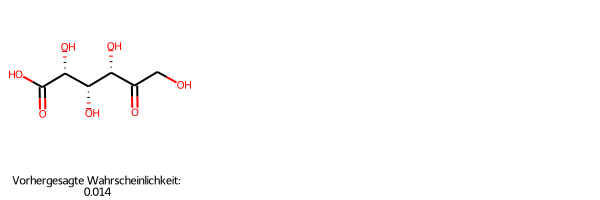

In [ ]:
falsch_klassifizierte=np.where(y_pred!=y)[0]
Draw.MolsToGridImage(mols[falsch_klassifizierte],
                     legends=["Vorhergesagte Wahrscheinlichkeit:\n"+str(np.round(x,3)) for x in y_hat[falsch_klassifizierte]],
                     useSVG=True)

## Y-Scrambling

Was auffällt ist, dass die Wahrscheinlichkeiten für diese Moleküle meistens relativ nah an 0.5 sind. Das heißt, für diese Moleküle war sich das Modell nicht sehr sicher. Insgesamt wurden aber nur 19 Moleküle falsch klassifiziert, wir sollten uns also nicht all zu viele Sorgen machen.

##### Das Problem:

*Hat das Model wirklich gelernt, was wichtig ist für den MMP Assay. Oder hat das RF Modell unsere Daten einfach nur auswendig gelernt?*

Wir können dies mit einem einfachen Test ausprobieren. Wir trainieren den RF noch einmal,zuvor vertauschen wir aber die `activity` Variable. Das heißt, die echten Messungen werden gemischt und neu auf die Moleküle verteilt. Dieser Prozess wird auch **Y-Scrambling** genannt. 

Angenommen unsere echten Daten sehen wie folgt aus:

smiles|Deskriptor 1| Deskriptor 2|activity
------|------------|-------------|--------
SMILES 1|$x_{1,1}$ |$x_{1,2}$|$y_1$
SMILES 2|$x_{2,1}$ |$x_{2,2}$|$y_2$
SMILES 3|$x_{3,1}$ |$x_{3,2}$|$y_3$
SMILES 4|$x_{4,1}$ |$x_{4,2}$|$y_4$

Für jeden SMILES wurden 2 Deskriptoren berechnet. Wir haben auch die Aktivität($y_1$-$y_4$) für jedes Molekül aufgezeichnet. Die Aktivität $y_1$ ist die gemessene Aktivität von SMILES 1 usw.

Nach dem *Y-scrambling* sehen unsere Daten so aus:

smiles|Deskriptor 1| Deskriptor 2|activity
------|------------|-------------|--------
SMILES 1|$x_{1,1}$ |$x_{1,2}$|$y_2$
SMILES 2|$x_{2,1}$ |$x_{2,2}$|$y_3$
SMILES 3|$x_{3,1}$ |$x_{3,2}$|$y_4$
SMILES 4|$x_{4,1}$ |$x_{4,2}$|$y_1$

Die $y$ Werte wurden zufällig anderen Molekülen zugeordnet.

Das Y-Scrambling führt dazu, dass die tatsächlichen Muster, die zwischen den `x` Variablen (also unseren Deskriptoren wie logP,...) und der Output Variable `y` bestehen, verloren gehen.  Das liegt daran, dass jetzt die Beziehung nur noch zufällig ist. Wenn unser Random Forest tatsächlich Muster lernt, anstatt die Daten auswendig zu lernen, dann sollte das Model auf diesem Datensatz schlechter funktionieren.

Um dies auszuprobieren brauchen Sie die library `random`. Mit der Funktion `random.shuffle()` werden die Werte von `y` zufällig neu sortiert. Sie können dann nochmal das Random Forest Modell trainieren.

In [ ]:
import random
random.seed(15) #ein Seed stell sicher das Sie alle die selbe zufälligen Daten erhalten
y_random=np.array(y) # erst speichern wir y in einem array
random.shuffle(y_random) # dann shuffeln wir y-random, wir müssen diese Variable nicht extra speichern

Wir haben gerade die Aktivitätsinformation gemischt. Wir können jetzt ein Random Forest Model trainieren. Diesmal benutzen wir aber nicht `y`, sondern `y_random`.

In [ ]:
# Das Model wird neu trainiert
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(x, y_random) # Welcher y Variable brauchen Sie
y_hat=rf.predict_proba(x)[:,1]

<details>
    <summary><b>Lösung:</b></summary>

```python
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(x, y_random) # Welcher y Variable brauchen Sie
y_hat=rf.predict_proba(x)[:,1]
```
</details>




Jetzt berechnen Sie erneut die Accuracy (achten Sie darauf, dass wir wieder `y_random` und nicht `y` für `y_true` benutzen):

In [ ]:
y_pred = np.round(y_hat)
accuracy(y_random, y_pred)

0.9229741763134461

Tatsächlich verschlechtert sich die Genauigkeit nach dem Y-Scrambling. Aber trotzdem ist die Genauigkeit über 90 %. Das Random Forest Modell ist immer noch relativ gut im Vorhersagen der toxikologischen Bedenklichkeit, obwohl die Daten, die Sie benutzt haben, gar keinen Sinn mehr ergeben. Das Modell konnte gar nicht lernen, weil es gar nichts zu lernen gab. Also hat das RF Modell seine Genauigkeit nur durch das Auswendiglernen erreicht. 

Darum benutzt man **immer** einen Testdatensatz. Dieses Testset wird nicht im Training benutzt, und somit sieht das Model diese Moleküle bei der Bewertung zum ersten Mal. Auswendiglernen kann immer noch passieren, wird dem Model aber nicht bei dem Validierungsset helfen.  

---
Oft werden Datensätze nicht nur in Train/Testset geteilt, sondern in Train/Validierung/Testset.
Die Modelle werden dann anhand des Validierungsset optimiert und nur das optimierte Model wird dann auf dem Testset getestet.
In der Chemieinformatik wird auch manchmal das Validierungsset Testset genannt. Das eigentlich Testset heißt dann Externes Validierungsset.

---
Auch hier gibt es wieder Funktionen, die Ihnen die Arbeit abnehmen. `train_test_split` teilt die Daten in ein Test (hier Validierungsset) und ein Trainingset. Wir benutzen 80 % des Datensatzes für das Training und die restlichen für das Validierungsset. Die Moleküle werden dann zufällig zwischen den beiden Sets aufgeteilt. Danach werden die Daten wieder in `x` und `y` getrennt, diesmal aber für `train` und `test` separat.



In [ ]:
train, test=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)

train_x = train.iloc[:,:7]
train_y = train.iloc[:,7]
test_x = test.iloc[:,:7]
test_y =  test.iloc[:,7]
f"Train Shape: {train.shape}, Test Shape: {test.shape}"

'Train Shape: (1796, 8), Test Shape: (450, 8)'

Der Trainingssatz enthält nur noch 1796 Moleküle und das Testset 450. 

Wir trainieren zunächst den Random Forest nur mit den Trainingsdaten:

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=1000, random_state=42)

Die Vorhersagen machen wir aber nur für die Moleküle im Validerungsset.

In [ ]:
y_hat=rf.predict_proba(test_x)[:,1]
y_pred = np.round(y_hat)

Wir können hetzt auch die Genauigkeit berechnen. Welche Variable brauchen wir jetzt für `y_true`?

In [ ]:
accuracy(test_y, y_pred)

0.8111111111111111

<details>
    <summary><b>Lösung:</b></summary>

```python
accuracy(test_y, y_pred)
```
</details>

Die Genauigkeit hat sich um einiges verschlechtert, ist aber immer noch gut. Allerdings können wir uns diesmal sicher sein, dass die Performance nicht durch Auswendiglernen zustande kam, da das Model vorher nie diese Moleküle gesehen hat. Wenn wir jetzt den Y-Scrambling Test anwenden, sollte die Performance drastisch schlechter werden. 
Wir ersetzen die `aux_data.activity` mit den vorhin erstellten `y_random`. Das sind die gemischten `y` Werte und wiederholen die Analyse.

In [ ]:
aux_data.activity = y_random 

Danach teilen wir wieder die Daten in Trainings- und Testset ein.

In [ ]:
train_random, test_random=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)
train_x_random = train_random.iloc[:,:7]
train_y_random = train_random.iloc[:,7]
test_x_random = test_random.iloc[:,:7]
test_y_random =  test_random.iloc[:,7]

Wir wiederholen wieder das Trainieren mit den randomisierten Daten. Danach lassen wir das Modell Vorhersagen für das Testset machen.

In [ ]:
# Train Model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x_random, train_y_random)
y_hat=rf.predict_proba(test_x_random)[:,1]

Als letztes berechnen wir noch die Genauigkeit. 

In [ ]:
y_pred = np.round(y_hat)
accuracy(test_y_random, y_pred)

0.5266666666666666

Mit dem Benutzen eines Testset fällt die Genauigkeit des Modells mit den Y-scrambled Daten drastisch auf ungefähr 50 %. Es ist nicht besser als ein Model, das einfach raten würde.
Erst durch das Benutzen eines Testset konnten wir zeigen, dass das Modell etwas über das Auswendiglernen hinaus gelernt hat.

Vor allem ging es darum zu zeigen, wie wichtig es ist, ein Model nicht auf dem Trainingsset zu bewerten. <br><br>
Das Y-Scrambeling wird nur selten in der Praxis benutzt. Aber die OECD fordert zum Beispiel, einen Y-Scrambling Test für das Validieren von Quantitive Structure-activity Relationship (QSAR) Models.

## Feature Importance

Als letzten Schritt schauen wir uns noch einmal die Feature Importance an. Die Feature Importance beurteilt, wie wichtig die einzelnen Variablen zur Entscheidung sind. Abhängig von welchem Machine Learning Algorithmus man benutzt kann man dies relativ leicht einsehen. Wir trainieren zunächst erneut unsere RF, diesmal mit einem Datensplit.

In [ ]:
aux_data.activity = data.activity

train, test=train_test_split(aux_data,test_size= 0.2, train_size= 0.8, random_state=1234)
train_x = train.iloc[:,:7]
train_y = train.iloc[:,7]
test_x = test.iloc[:,:7]
test_y =  test.iloc[:,7]


# Train Model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)
y_hat=rf.predict_proba(test_x)[:,1]


In der nächsten Zelle trainieren wir zuerst noch einmal das Random Forest Modell (ohne y scrambling) und lassen uns dann in den letzten beiden Zeilen die Feature Importance anzeigen.

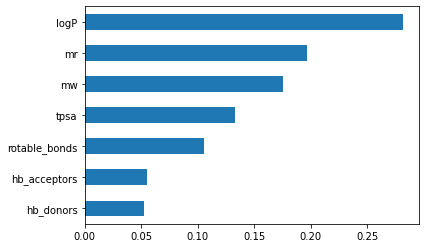

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=aux_data.columns.values[:-1])
feat_importances.nlargest(20).nsmallest(20).plot(kind='barh')

Es wird deutlich ersichtlich, dass der LogP der wichtigste Parameter für die Bestimmung der Toxizität ist, während die Anzahl an H-Brücken-Donoren und -Akzeptoren weniger relevant ist. <br><br> Da wir für Menschen verständliche Deskriptoren als Features gewählt haben, können wir uns auch gut anschauen welchen Einfluss ein einzelner Parameter auf die Aktivität hat (das hätten wir auch tatsächlich schon vor dem Trainieren machen können). <br><br> Zuerst lassen wir uns die Aktivitätsverteilung in Abhängigkeit vom LogP anzeigen.

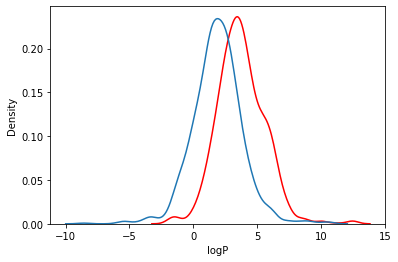

In [ ]:
import seaborn as sns
sns.kdeplot(aux_data.logP[aux_data.activity==1], color="red")
sns.kdeplot(aux_data.logP[aux_data.activity==0])

Hier sehen wir einen deutlichen Trend. Bei höherem LogP ist das Molekül wahrscheinlicher aktiv. <br> <br>Probieren sie das einmal selbst mit den anderen Deskriptoren aus (`hb_donors`, `hb_acceptors`, `rotable_bonds`, `mw`, `mr`, `tpsa`). Welche Deskriptoren zeigen außer dem LogP noch unterschiedlich verteilte Aktivitäten?

# Übungsaufgabe 

Sie haben ja bereits Fingerprints als Molekülrepresentationen kennengelernt. Da diese einfach zu berechnen sind und immer eine fest definierte Länge haben, sind sie gut als Features für Machine Learning geeignet. Allerdings sind Fingerprints weniger leicht für Menschen zu interpretieren.

Ihre Aufgabe wird es sein, nochmals ein Random Forest Modell zu trainieren. Diesmal werden Sie die Fingerprints als Input nehmen.

<br><br>Für Sie wurde die `get_fingerprints()` Funktion schon vorgeschrieben. Mit der lassen sich Fingerprints aus den SMILES berechnen.

In [ ]:
fps = get_fingerprints(data)
fps["activity"] = data.activity
fps.head()

100%|██████████| 2246/2246 [00:04<00:00, 464.82it/s]


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,activity
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`fps` enthält insgesamt 2049 Spalten. 2048 davon sind die jeweiligen Bits des Fingerprints. Die letzte Spalte enthält die `activity`.

Teilen Sie zunächst den Datensatz in `train` und `test`. 80 % der Daten sollen in das Trainingsset und 20 % in das Testset.

In [ ]:
train, val=train_test_split(fps,test_size= 0.2 , train_size= 0.8, random_state=1234)

train_x = fps.iloc[:,:2048]
train_y = fps.iloc[:,2048]
test_x = fps.iloc[:,:2048]
test_y = fps.iloc[:,2048] 

Nachdem Sie die Daten geteilt haben, trainieren Sie einen Random Forest Classifier mithilfe des Trainingsdatensatzes.
Mit dem trainierten Modell klassifizieren Sie dann die Moleküle im Test Datensatz `test`.

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_x.values, train_y.values)
y_hat=rf.predict_proba(test_x)[:,1]

Berrechnen Sie den ROC-AUC, denken Sie daran, dass Sie vorher die Wahrscheinlichkeiten runden müssen.

In [ ]:
y_pred = np.round(y_hat)
roc_auc_score(test_y,y_pred)

0.9951024042742654

Wir können uns auch wieder die Feature Importance anschauen:

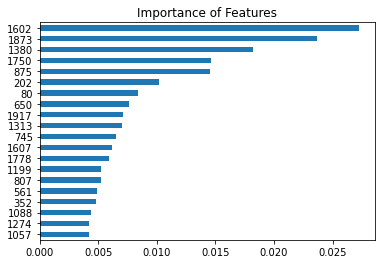

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=range(2048))
feat_importances.nlargest(20).nsmallest(20).plot(kind='barh', title = "Importance of Features")

Dieser Plot lässt sich leider nicht mehr so gut interpretieren, auch wenn deutlich wird, dass die obersten fünf Bits wichtig für die Aktivität sind. Leider kann man die Bits nicht so gut darstellen, aber es lassen sich die Fragmente, die jedem Bit zugeordnet sind mit RDKit zeigen:

Die 20 wichtigsten bits: [1602 1873 1380 1750  875  202   80  650 1917 1313  745 1607 1778 1199
  807  561  352 1088 1274 1057]


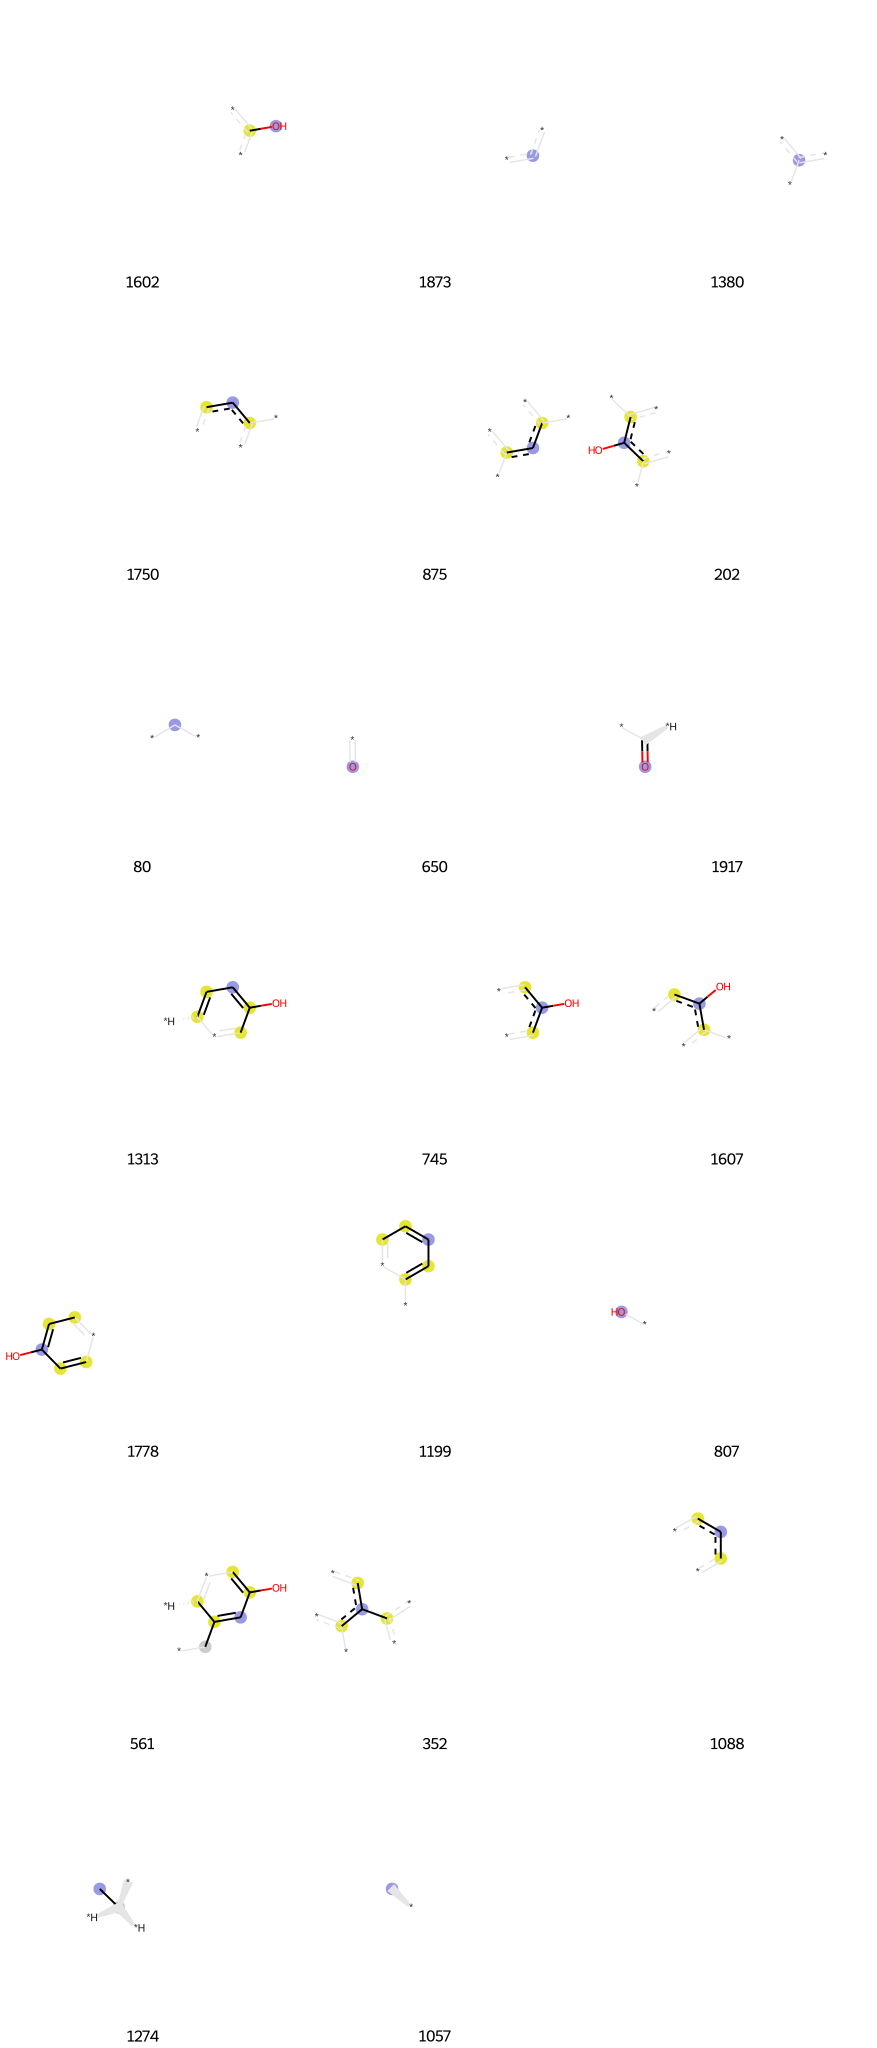

In [ ]:
most_important_bits = feat_importances.nlargest(20).index.values
print("Die 20 wichtigsten bits:", most_important_bits)
mol_ll = []
bi_ll = []


for i in range(20):
    bit = most_important_bits[i]
    for x in data.smiles:
        bi ={}
        mol = Chem.MolFromSmiles(x)
        fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
        if np.sum(np.array(list(bi))==bit)>0:
            mol_ll.append(mol)
            bi_ll.append(bi)
            break
        
prints=[(mol_ll[i],most_important_bits[i], bi_ll[i]) for i in range(20)]

Draw.DrawMorganBits(prints, useSVG=True, molsPerRow=3, legends= [str(most_important_bits[i]) for i in range(20)], subImgSize= [300,300])

Das wichtigste Bit ist für unsere Daten eine phenolische Hydroxygruppe (aromatische Atome sind gelb hervorgehoben, das zentrale Atom ist blau). Auch sonst sind viele aromatische Fragmente in den wichtigsten Bits vertreten.